# Chapter-3 Classification

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml("mnist_784", version=1) 

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [8]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape, type(X)

((70000, 784), (70000,), pandas.core.frame.DataFrame)

In [5]:
# there are 70K images, each has 784 features. This is cause each image is 
# 28 X 28 pixels, and each feature simply represents one pixel's intensity.

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
X = X.to_numpy()

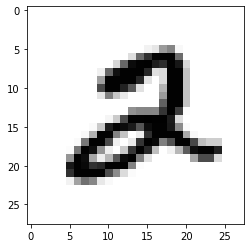

In [22]:
some_digit = X[5]
some_digit = some_digit.reshape(28,28)
plt.imshow(some_digit, cmap=mpl.cm.binary, interpolation="nearest")

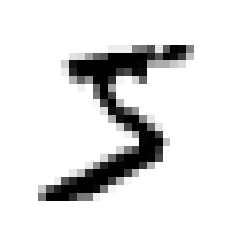

In [23]:

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [24]:
y[0]

'5'

In [25]:
# note the label is string. We prefer numbers
y = y.astype(np.uint8)

In [26]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
# The training set is already shuffled for us, which is good as this guarantees that all
# cross-validation folds will be similar (you don’t want one fold to be missing some digits).
# Moreover, some learning algorithms are sensitive to the order of the training
# 2 Shuffling may be a bad idea in some contexts—for example, if you are working on time series data (such as
# stock market prices or weather conditions). We will explore this in the next chapters.
# instances, and they perform poorly if they get many similar instances in a row. Shuffling
# the dataset ensures that this won’t happen.2

# Training a Binary classifier

In [13]:
# Let’s simplify the problem for now and only try to identify one digit—for example,
# the number 5. This “5-detector” will be an example of a binary classifier, capable of
# distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for
# this classification task:
y_train_5 = (y_train == 5) # True for all 5s, False for other digits
y_test_5 = (y_test == 5)

In [14]:
# now pick a classifier and train it. We will be using a stochastic gradient descent(SGD)
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [20]:
# The SGDClassifier relies on randomness during training (hence
# the name “stochastic”). If you want reproducible results, you
# should set the random_state parameter.

In [15]:
# now we can use it to detect images of number 5
sgd_clf.predict([some_digit])

array([ True])

## performace measures

### measuring accuracy using cross-validation
### implementing cross-validation

In [22]:
# Occasionally you will need more control over the cross-validation process than what
# Scikit-Learn provides off-the-shelf. In these cases, you can implement crossvalidation
# yourself; it is actually fairly straightforward. The following code does
# roughly the same thing as Scikit-Learn’s cross_val_score() function, and prints the
# same result:

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

# The StratifiedKFold class performs stratified sampling (as explained in Chapter 2)
# to produce folds that contain a representative ratio of each class. At each iteration the
# code creates a clone of the classifier, trains that clone on the training folds, and makes
# predictions on the test fold. Then it counts the number of correct predictions and
# outputs the ratio of correct predictions.

0.9669
0.91625
0.96785


In [23]:
# Let’s use the cross_val_score() function to evaluate your SGDClassifier model
# using K-fold cross-validation, with three folds. Remember that K-fold crossvalidation
# means splitting the training set into K-folds (in this case, three), then making
# predictions and evaluating them on each fold using a model trained on the
# remaining folds

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [17]:
# let’s look at a very
# dumb classifier that just classifies every single image in the “not-5” class:

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
# now test accuracy
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [19]:
# That’s right, it has over 90% accuracy! This is simply because only about 10% of the
# images are 5s, so if you always guess that an image is not a 5, you will be right about
# 90% of the time. Beats Nostradamus.

# This demonstrates why accuracy is generally not the preferred performance measure
# for classifiers, especially when you are dealing with skewed datasets (i.e., when some
# classes are much more frequent than others).

## confusion matrix

In [20]:
# The general idea is to count the number of times instances of class A are
# classified as class B. For example, to know the number of times the classifier confused
# images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion
# matrix.
# To compute the confusion matrix, you first need to have a set of predictions, so they
# can be compared to the actual targets. You could make predictions on the test set, but
# let’s keep it untouched for now (remember that you want to use the test set only at the
# very end of your project, once you have a classifier that you are ready to launch).
# Instead, you can use the cross_val_predict() function:

In [21]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [23]:
# but instead of returning the evaluation scores, it returns the 
# predictions made on each test fold.
y_train_5.shape, y_train_pred.shape, y_train_5

((60000,),
 (60000,),
 0         True
 1        False
 2        False
 3        False
 4        False
          ...  
 59995    False
 59996    False
 59997     True
 59998    False
 59999    False
 Name: class, Length: 60000, dtype: bool)

In [22]:
# now confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [24]:
# Each row in a confusion matrix represents an actual class, while each column represents
# a predicted class. The first row of this matrix considers non-5 images (the negative
# class): 53,892 of them were correctly classified as non-5s (they are called true
# negatives), while the remaining 687 were wrongly classified as 5s (false positives).
# The second row considers the images of 5s (the positive class): 1891 were wrongly
# classified as non-5s (false negatives), while the remaining 3530 were correctly classified
# as 5s (true positives). A perfect classifier would have only true positives and true
# negatives, so its confusion matrix would have nonzero values only on its main diagonal
# (top left to bottom right):

In [26]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [25]:
# precision of a classifier 
# precision = tp/(tp + fp)
# tp is no of true positives, fp is no of fake positives

In [35]:
# recall = tp/(tp + fn)
# see page->94 for diagram..

## precision and recall 

In [27]:
# these are classifier metrics
from sklearn.metrics import precision_score, recall_score

In [28]:
precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)
# Now your 5-detector does not look as shiny as it did when you looked at its accuracy.
# When it claims an image represents a 5, it is correct only 72.9% of the time. Moreover,
# it only detects 75.6% of the 5s.

(0.8370879772350012, 0.6511713705958311)

In [29]:
# we combine precision and recall into a single metric called F1 score.
# F1 score is harmonic mean of precesion and recall. 
# Whereas the regular mean treats all values equally, the harmonic mean gives 
# much more weight to low values.

In [30]:
# F1 = 2 * (precision * recall)/(precision + recall)
# computing F1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [31]:
# decision_function() method, which returns a
# score for each instance, and then make predictions based on those scores using any
# threshold you want:
y_scores = sgd_clf.decision_function([some_digit])
y_scores
# read page->95

array([2164.22030239])

In [33]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [35]:
# The SGDClassifier uses a threshold equal to 0, so the previous code returns the same
# result as the predict() method (i.e., True). Let’s raise the threshold:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred
# This confirms that raising the threshold decreases recall. The image actually represents
# a 5, and the classifier detects it when the threshold is 0, but it misses it when the
# threshold is increased to 8,000.

# read page->95


array([False])

In [43]:
# now we will decided which threshold score to use, so we first get the scores.. by using..
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [44]:
y_scores
# Now with these scores you can compute precision and recall for all possible thresholds
# using the precision_recall_curve() function:

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [45]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

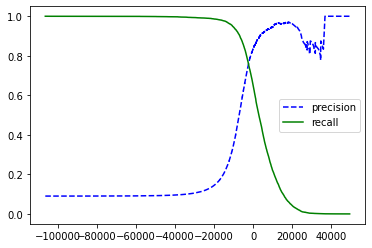

In [47]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(["precision", "recall"])
    [...] # highlight the threshold, add the legend, axis label and grid
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [48]:
# see page->97..
# we can also plot precision directly against recall see page->98

In [50]:
# this is for precision to be 90.. do check pages. mentioned
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [51]:
# To make predictions (on the training set for now), instead of calling the classifier’s
# predict() method, you can just run this code:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [53]:
# now check predictions precision and recall
precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)


(0.9000345901072293, 0.4799852425751706)

In [54]:
# so in all we can train a classifier at any precision or recall.. just go through again to see how..
# But:::: a high-precision classifier is not very useful if its recall is too low

## the ROC curve

In [56]:
# The receiver operating characteristic (ROC) curve is another common tool used with
# binary classifiers. It is very similar to the precision/recall curve, but instead of plotting
# precision versus recall, the ROC curve plots the true positive rate (another name
# for recall) against the false positive rate. The FPR is the ratio of negative instances that
# are incorrectly classified as positive. It is equal to one minus the true negative rate,
# which is the ratio of negative instances that are correctly classified as negative. The
# TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus
# 1 – specificity.

In [57]:
# so we need to compute TPR and FPR
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

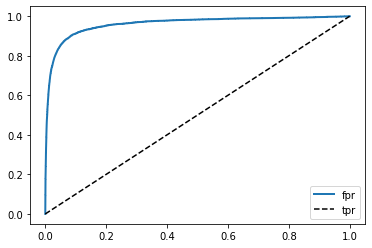

In [60]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.legend(["fpr", "tpr"])
    [...] # Add axis labels and grid
plot_roc_curve(fpr, tpr)
plt.show()

In [61]:
# Once again there is a tradeoff: the higher the recall (TPR), the more false positives
# (FPR) the classifier produces. The dotted line represents the ROC curve of a purely
# random classifier; a good classifier stays as far away from that line as possible (toward
# the top-left corner).
# One way to compare classifiers is to measure the area under the curve (AUC). A perfect
# classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
# have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC
# AUC:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [62]:
# do read page->100 , tells when to use which curve

In [66]:
# now we will compare the sdg classifier wiht a randomforest one
# don't worry we will learn randomforest classifier in chapter 7

# skipping the page->101 cause ... we will learn it later so..

# Hopefully you now know how to train binary classifiers, choose the appropriate metric
# for your task, evaluate your classifiers using cross-validation, select the precision/
# recall tradeoff that fits your needs, and compare various models using ROC curves
# and ROC AUC scores. Now let’s try to detect more than just the 5s.

## Multiclass classification

In [67]:
# skipped whole chapter from now on ..upto 113 i.e. next chapter
# do read it after .. learning all about these...